# Desafio 1 da aula de Modelagem de Dados:

Tenho como objetivo criar um modelo que, com base nos pontos dados no arquivo 'Desafio_01_ModData2025', consiga fittar os pontos de maneira satisfatória e gerar como output o f(0) e o f(10).

Para tal tarefa primeiro vamos usar um modelo paramétrico de uma senoide amortecida, valendo-se da análise qualitativa dos pontos estarem distríbuidos de uma forma que parecem formar a curva de um pêndulo amortecido.

Após implementar o modelo supracitado vou tentar usar o modelo de Regressão por Processos Gaussianos, que funciona inferindo uma distribuição de probabilidade sobre todas as funções possíveis que se ajustam para os dados. O objetivo será abrir o arquivo com os dados e implementar o modelo de regressão do zero, usando somente numpy. 

Dessa forma, poderei entender melhor como funciona o modelo e como ele interage com os dados, conseguido muito mais conhecimento do que somente implementando uma função do scikit learn.

Abaixo terão todas as linhas de código e as devidas explicações para facilitar o meu processo de aprendizado e o entendimento do leitor.

## Importando os dados

Dados carregados com sucesso de 'C:\Users\felip\Downloads\Desafio_01_ModData2025.txt'.
Foram encontrados 111 pontos.


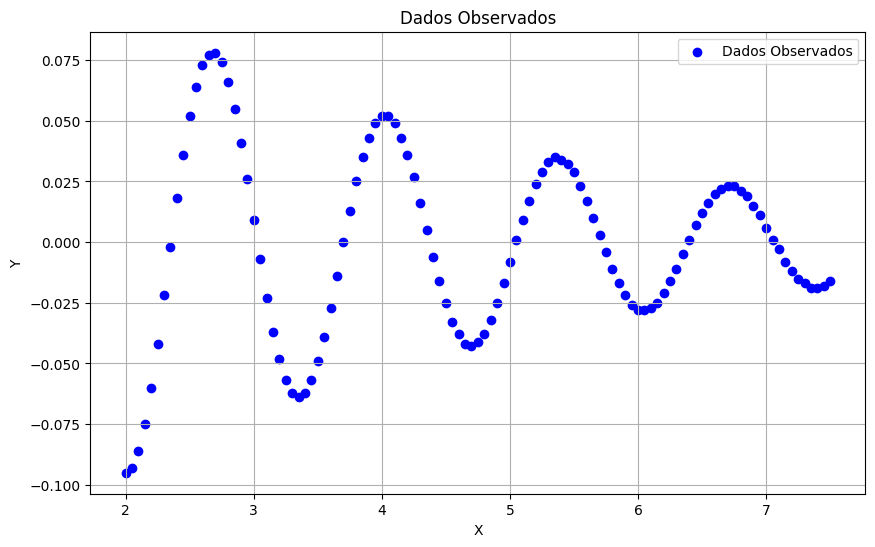

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Carregar os dados do arquivo
data = np.loadtxt(r"C:\Users\felip\Downloads\Desafio_01_ModData2025.txt", encoding='utf-8-sig', skiprows=1) #Pula a primeira linha que é o cabeçalho
#Separar os dados em X e Y
x_dados = data[:, 0]
y_dados = data[:, 1]
print(f"Dados carregados com sucesso de '{r"C:\Users\felip\Downloads\Desafio_01_ModData2025.txt"}'.")
print(f"Foram encontrados {len(x_dados)} pontos.")

# Visualizar os dados
plt.figure(figsize=(10, 6))
plt.scatter(x_dados, y_dados, color='blue', label='Dados Observados')
plt.title('Dados Observados')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.show()

## Regressão por Modelo Parmétrico (Senoide Amortecida)

A equação para a Senoide Amortecida é a seguinte:

$$
f(t) = A \cdot e^{-Bt} \sin(\omega t + \phi) + C
$$

O objetivo primário é ultilizar o algorítimo de Gauss-Newton para calcular os Mínimos Quadrados Não-Lineares.

Para minimizar a Soma dos Quadrados dos Resíduos vamos fazer uso das fórmulas:

Resíduo:

$$
r_i(\boldsymbol{p}) = y_i - f(x_i, \boldsymbol{p})
$$

Soma dos Quadrados dos Resíduos:

$$
S(\boldsymbol{p}) = \sum_{i=1}^{n} r_i(\boldsymbol{p})^2 = \sum_{i=1}^{n} \left( y_i - f(x_i, \boldsymbol{p}) \right)^2
$$

O algorítmo de Gauss-Newton aproxíma um problema não linear difícil para uma série de problemas de mínimos quadrados lineares, iniciando com um "chute" inicial para os parâmetros, linearizando o modelo para esse chute e por fim atualizando ele até que a correção do modelo seja muito pequena e ele não melhore mais. 

Para começarmos o nosso modelo temos que calcular a Matriz Jacobiana:

$$
J_{ij} = \frac{\partial f(x_i, \boldsymbol{p})}{\partial p_j}
$$

Após esse passo calculamos a Equação Normal:

$$
J_{ij} = \frac{\partial f(x_i, \boldsymbol{p})}{\partial p_j}
$$

Depois resolvemos para Delta:

$$
\Delta \boldsymbol{p} = (\mathbf{J}^T \mathbf{J})^{-1} \mathbf{J}^T \mathbf{r}
$$

E por fim atualizamos nossos parâmetros e começamos a próxima iteração:

$$
\boldsymbol{p}_{k+1} = \boldsymbol{p}_k + \Delta\boldsymbol{p}
$$

In [16]:
# --- Implementação do Algoritmo de Gauss-Newton com NumPy ---

def damped_sine_params(x, params):
    """
    Nossa função modelo que aceita os parâmetros como um único array.
    Isso facilita o trabalho dentro do loop de otimização.
    """
    A, B, omega, phi, C = params
    return A * np.exp(-B * x) * np.sin(omega * x + phi) + C

def calculate_jacobian_numerical(model_func, x_data, params):
    """
    Calcula a Matriz Jacobiana de um modelo usando diferenças finitas (aproximação numérica).
    """
    num_params = len(params)
    num_points = len(x_data)
    J = np.zeros((num_points, num_params))
    h = 1e-6  # Um passo muito pequeno para a derivada

    for j in range(num_params):
        # Cria uma cópia dos parâmetros para não modificar o original
        params_plus_h = params.copy()
        
        # Adiciona o pequeno passo 'h' ao j-ésimo parâmetro
        params_plus_h[j] += h
        
        # Calcula a previsão do modelo com o parâmetro perturbado
        y_pred_plus_h = model_func(x_data, params_plus_h)
        
        # Calcula a previsão do modelo com os parâmetros originais
        y_pred = model_func(x_data, params)
        
        # Calcula a derivada parcial (a j-ésima coluna do Jacobiano)
        partial_derivative = (y_pred_plus_h - y_pred) / h
        J[:, j] = partial_derivative
        
    return J

def gauss_newton_optimizer(model_func, jacobian_func, x_data, y_data, initial_params, iterations=20, tolerance=1e-8):
    """
    Executa o algoritmo de otimização de Gauss-Newton para encontrar os melhores parâmetros.
    """
    # Converte a lista de chutes iniciais para um array NumPy
    params = np.array(initial_params, dtype=float)
    
    print("--- Iniciando Otimização de Gauss-Newton ---")
    
    for i in range(iterations):
        # 1. Calcular resíduos
        y_pred = model_func(x_data, params)
        residuals = y_data - y_pred
        
        # 2. Calcular a Matriz Jacobiana
        J = jacobian_func(model_func, x_data, params)
        
        # 3. Resolver a equação normal: (J^T * J) * delta_p = J^T * r
        JtJ = J.T @ J
        Jt_r = J.T @ residuals
        
        # Usar np.linalg.solve é numericamente mais estável do que calcular a inversa
        try:
            delta_p = np.linalg.solve(JtJ, Jt_r)
        except np.linalg.LinAlgError:
            print("Erro: Matriz singular. A otimização não pode continuar.")
            break
            
        # 4. Atualizar os parâmetros
        params += delta_p
        
        # Imprimir o progresso
        ssr = np.sum(residuals**2)
        print(f"Iteração {i+1:2d}: SSR = {ssr:.6f}, Norma do Passo = {np.linalg.norm(delta_p):.6f}")
        
        # 5. Critério de parada (se o passo de atualização for muito pequeno)
        if np.linalg.norm(delta_p) < tolerance:
            print("\nConvergência atingida.")
            break
            
    print("--- Otimização Concluída ---")
    return params

# --- Execução do Otimizador ---

# Seus dados que já foram carregados
# x_dados = ...
# y_dados = ...

# Estimativas iniciais que discutimos anteriormente
# Ordem: [A, B, omega, phi, C]
initial_guesses = [0.12, 0.3, 4.65, 0.0, 0.0]

# Chamar o otimizador
optimized_params = gauss_newton_optimizer(
    damped_sine_params,
    calculate_jacobian_numerical,
    x_dados,
    y_dados,
    initial_guesses
)

# Exibir os parâmetros finais encontrados
print("\n--- Parâmetros Otimizados Finais ---")
param_names = ['A', 'B', 'omega', 'phi', 'C']
for name, value in zip(param_names, optimized_params):
    print(f"{name} = {value:.6f}")

--- Iniciando Otimização de Gauss-Newton ---
Iteração  1: SSR = 0.224314, Norma do Passo = 1.468609
Iteração  2: SSR = 0.154337, Norma do Passo = 335.852335
Iteração  3: SSR = inf, Norma do Passo = nan
Iteração  4: SSR = nan, Norma do Passo = nan
Iteração  5: SSR = nan, Norma do Passo = nan
Iteração  6: SSR = nan, Norma do Passo = nan
Iteração  7: SSR = nan, Norma do Passo = nan
Iteração  8: SSR = nan, Norma do Passo = nan
Iteração  9: SSR = nan, Norma do Passo = nan
Iteração 10: SSR = nan, Norma do Passo = nan
Iteração 11: SSR = nan, Norma do Passo = nan
Iteração 12: SSR = nan, Norma do Passo = nan
Iteração 13: SSR = nan, Norma do Passo = nan
Iteração 14: SSR = nan, Norma do Passo = nan
Iteração 15: SSR = nan, Norma do Passo = nan
Iteração 16: SSR = nan, Norma do Passo = nan
Iteração 17: SSR = nan, Norma do Passo = nan
Iteração 18: SSR = nan, Norma do Passo = nan
Iteração 19: SSR = nan, Norma do Passo = nan
Iteração 20: SSR = nan, Norma do Passo = nan
--- Otimização Concluída ---

---

C:\Users\felip\AppData\Local\Temp\ipykernel_7496\1802244074.py:57: RuntimeWarning: overflow encountered in matmul
  JtJ = J.T @ J
C:\Users\felip\AppData\Local\Temp\ipykernel_7496\1802244074.py:58: RuntimeWarning: overflow encountered in matmul
  Jt_r = J.T @ residuals
C:\Users\felip\AppData\Local\Temp\ipykernel_7496\1802244074.py:58: RuntimeWarning: invalid value encountered in matmul
  Jt_r = J.T @ residuals
C:\Users\felip\AppData\Local\Temp\ipykernel_7496\1802244074.py:71: RuntimeWarning: overflow encountered in square
  ssr = np.sum(residuals**2)


In [17]:
def levenberg_marquardt_optimizer(model_func, jacobian_func, x_data, y_data, initial_params, iterations=20, tolerance=1e-8, initial_lambda=1e-2):
    """
    Executa o algoritmo de otimização de Levenberg-Marquardt.
    """
    params = np.array(initial_params, dtype=float)
    lmbda = initial_lambda # O 'freio' ou 'amortecedor'
    
    # Calcula o erro inicial
    y_pred = model_func(x_data, params)
    residuals = y_data - y_pred
    current_ssr = np.sum(residuals**2)
    
    print("--- Iniciando Otimização de Levenberg-Marquardt ---")
    print(f"Iteração  0: SSR = {current_ssr:.6f}")

    for i in range(iterations):
        # 1. Calcular a Matriz Jacobiana
        J = jacobian_func(model_func, x_data, params)
        
        # 2. Resolver a equação de Levenberg-Marquardt
        JtJ = J.T @ J
        Jt_r = J.T @ residuals
        
        # Adiciona o amortecedor lambda à diagonal
        JtJ_damped = JtJ + lmbda * np.eye(len(params))
        
        try:
            delta_p = np.linalg.solve(JtJ_damped, Jt_r)
        except np.linalg.LinAlgError:
            print("Erro: Matriz singular. Aumentando lambda e tentando novamente.")
            lmbda *= 10
            continue
            
        # 3. Propor um novo conjunto de parâmetros e ver se o erro melhora
        proposed_params = params + delta_p
        y_pred_proposed = model_func(x_data, proposed_params)
        residuals_proposed = y_data - y_pred_proposed
        proposed_ssr = np.sum(residuals_proposed**2)
        
        # 4. Aceitar ou rejeitar o passo
        if proposed_ssr < current_ssr:
            # Passo foi bom! Aceita e fica mais 'confiante'
            params = proposed_params
            residuals = residuals_proposed
            current_ssr = proposed_ssr
            lmbda /= 10 # Diminui o freio
            print(f"Iteração {i+1:2d}: SSR = {current_ssr:.6f} (Passo aceito), Lambda = {lmbda:.2e}")
        else:
            # Passo foi ruim! Rejeita e fica mais 'cauteloso'
            lmbda *= 10 # Aumenta o freio
            print(f"Iteração {i+1:2d}: SSR = {current_ssr:.6f} (Passo rejeitado), Lambda = {lmbda:.2e}")

        # 5. Critério de parada
        if np.linalg.norm(delta_p) < tolerance:
            print("\nConvergência atingida.")
            break
            
    print("--- Otimização Concluída ---")
    return params

# --- Execução do Otimizador (agora chamando a nova função) ---

initial_guesses = [0.12, 0.3, 4.65, 0.0, 0.0]

optimized_params_lm = levenberg_marquardt_optimizer(
    damped_sine_params,
    calculate_jacobian_numerical,
    x_dados,
    y_dados,
    initial_guesses
)

# Exibir os parâmetros finais encontrados
print("\n--- Parâmetros Otimizados Finais (Levenberg-Marquardt) ---")
param_names = ['A', 'B', 'omega', 'phi', 'C']
for name, value in zip(param_names, optimized_params_lm):
    print(f"{name} = {value:.6f}")

--- Iniciando Otimização de Levenberg-Marquardt ---
Iteração  0: SSR = 0.224314
Iteração  1: SSR = 0.140312 (Passo aceito), Lambda = 1.00e-03
Iteração  2: SSR = 0.140312 (Passo rejeitado), Lambda = 1.00e-02
Iteração  3: SSR = 0.140312 (Passo rejeitado), Lambda = 1.00e-01
Iteração  4: SSR = 0.010165 (Passo aceito), Lambda = 1.00e-02
Iteração  5: SSR = 0.002099 (Passo aceito), Lambda = 1.00e-03
Iteração  6: SSR = 0.000021 (Passo aceito), Lambda = 1.00e-04
Iteração  7: SSR = 0.000008 (Passo aceito), Lambda = 1.00e-05
Iteração  8: SSR = 0.000008 (Passo aceito), Lambda = 1.00e-06
Iteração  9: SSR = 0.000008 (Passo aceito), Lambda = 1.00e-07
Iteração 10: SSR = 0.000008 (Passo aceito), Lambda = 1.00e-08

Convergência atingida.
--- Otimização Concluída ---

--- Parâmetros Otimizados Finais (Levenberg-Marquardt) ---
A = 0.175115
B = 0.301094
omega = 4.669518
phi = 1.569726
C = 0.000016



--- Resultados Finais para a Competição ---
O valor previsto para f(0) é: 0.175131
O valor previsto para f(10) é: -0.007823


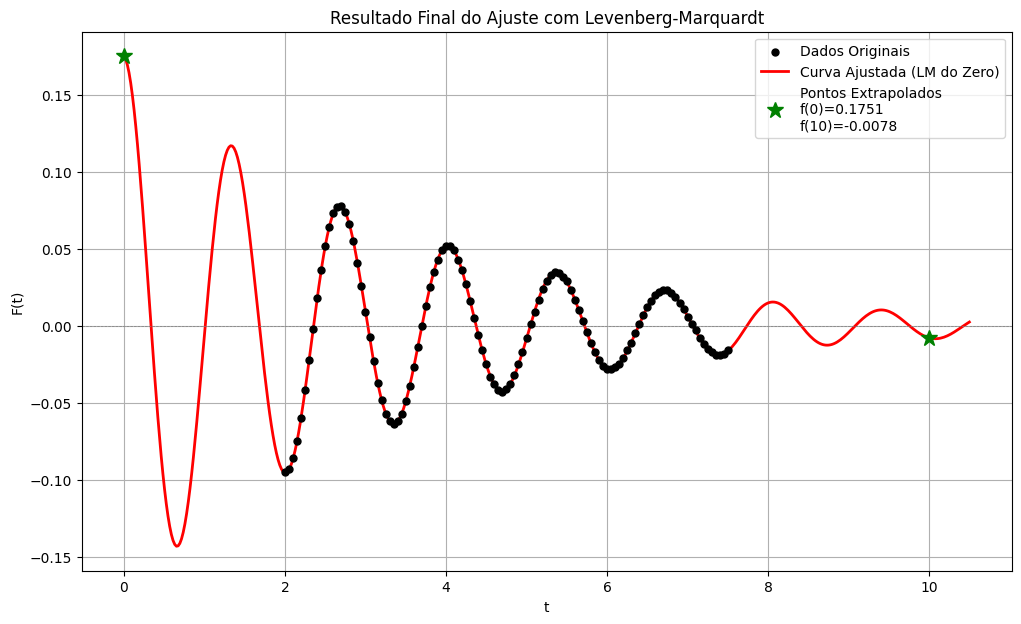

In [18]:
# A variável com os parâmetros que você encontrou
optimized_params_lm = np.array([0.175115, 0.301094, 4.669518, 1.569726, 0.000016])

# --- 1. Calcular os valores para a competição ---

# Usamos nossa função modelo com x=0 e x=10 e os parâmetros otimizados
f0 = damped_sine_params(0, optimized_params_lm)
f10 = damped_sine_params(10, optimized_params_lm)

print("\n--- Resultados Finais para a Competição ---")
print(f"O valor previsto para f(0) é: {f0:.6f}")
print(f"O valor previsto para f(10) é: {f10:.6f}")


# --- 2. Visualizar a qualidade do ajuste ---

# Criar um array de pontos suave para plotar a curva
x_fit = np.linspace(0, 10.5, 500)
y_fit = damped_sine_params(x_fit, optimized_params_lm)

plt.figure(figsize=(12, 7))

# Plotar os dados originais
plt.scatter(x_dados, y_dados, c='black', label='Dados Originais', s=25, zorder=3)

# Plotar a curva ajustada pelo nosso otimizador
plt.plot(x_fit, y_fit, 'r-', linewidth=2, label='Curva Ajustada (LM do Zero)', zorder=2)

# Destacar os pontos extrapolados
plt.plot([0, 10], [f0, f10], 'g*', markersize=12, label=f'Pontos Extrapolados\nf(0)={f0:.4f}\nf(10)={f10:.4f}', zorder=4)

plt.title('Resultado Final do Ajuste com Levenberg-Marquardt')
plt.xlabel('t')
plt.ylabel('F(t)')
plt.legend()
plt.grid(True)
plt.axhline(0, color='grey', linestyle='--', linewidth=0.5) # Linha de referência em y=0
plt.show()

## Regressão por Processos Gaussianos

Agora vamos implementar o Kernel k(x,x′) que mede a "similaridade" entre dois pontos. O Kernel mais comum segundo as minhas pesquisas é o seguinte:
$$
k_{\text{RBF}}(x, x') = \sigma_f^2 \exp\left(-\frac{(x - x')^2}{2l^2}\right)
$$
Onde:
$\sigma_f^2$ controla a variação vertical da função

$l$ controla a suavidade da função

Também vamos implementar a previsão baseada na suposição que a matriz de treino e de teste obedecem a distribuição Gaussiana Multivariada conjunta:
$$
\begin{bmatrix} \mathbf{y} \\ \mathbf{f}_* \end{bmatrix} \sim \mathcal{N} \left( \mathbf{0}, \begin{bmatrix} K(X, X) + \sigma_n^2 I & K(X, X_*) \\ K(X_*, X) & K(X_*, X_*) \end{bmatrix} \right)
$$ 

Onde X é X_dados e $\sigma_n^2$ é a variância do ruído, termo que adicionamos para estabilidade numérica e para modelar o ruído nos dados.

Usando as regras de condicionamento de distribuições Gaussianas, obtemos a distribuição posterior:

$$
\boldsymbol{\mu}_* = K(X_*, X) \left[ K(X, X) + \sigma_n^2 I \right]^{-1} \mathbf{y}
$$

Covariância Preditiva:

$$
\Sigma_* = K(X_*, X_*) - K(X_*, X) \left[ K(X, X) + \sigma_n^2 I \right]^{-1} K(X, X_*)
$$


In [13]:
def kernel_rbf(A, B, length_scale, sigma_f):
    """Calcula o kernel RBF entre dois conjuntos de pontos A e B."""
    sqdist = np.sum(A**2, 1).reshape(-1, 1) + np.sum(B**2, 1) - 2 * np.dot(A, B.T)
    return sigma_f**2 * np.exp(-0.5 / length_scale**2 * sqdist)
def gpr_predict(x_train, y_train, x_test, length_scale, sigma_f, sigma_n): 
    """Realiza a regressão por processos gaussianos.
    Args:
        x_train: Os pontos x dos dados de treinamento.
        y_train: Os pontos y dos dados de treinamento.
        x_test: Os pontos x onde queremos fazer a predição. # <-- Agora consistente
        length_scale (l): O hiperparâmetro de escala de comprimento do kernel.
        sigma_f (sf): O hiperparâmetro de variância do sinal do kernel.
        sigma_n (sn): O hiperparâmetro do ruído dos dados.

    Returns:
        A média preditiva (mu_star) e a covariância preditiva (cov_star)."""
    # Vamos garantir que os vetores de entrada sejam 2D
    if x_train.ndim == 1:
        x_train = x_train.reshape(-1, 1)
    if x_test.ndim == 1: # <-- CORREÇÃO 1: Agora funciona, pois o parâmetro é x_test
        x_test = x_test.reshape(-1, 1)
        
    # Calcular as matrizes de covariância usando o kernel RBF
    K = kernel_rbf(x_train, x_train, length_scale, sigma_f) 
    K_star = kernel_rbf(x_train, x_test, length_scale, sigma_f)
    K_star_star = kernel_rbf(x_test, x_test, length_scale, sigma_f)
    
    # Adicionar o ruído à diagonal de K e calcular a inversa
    K_inv = np.linalg.inv(K + sigma_n**2 * np.eye(len(x_train)))
    
    # Calcular a média preditiva e a covariância preditiva
    mu_star = K_star.T @ K_inv @ y_train
    cov_star = K_star_star - K_star.T @ K_inv @ K_star
    
    return mu_star, cov_star

In [14]:
#definindo os hiperparâmetros
l = 1.0  # escala de comprimento
sf = 1.5  # variância do sinal
sn = 0.3  # ruído dos dados
x_test = np.linspace(0, 10, 200)
print("\nExecutando a Regressão por Processo Gaussiano...")
mu_pred, cov_pred = gpr_predict(x_dados, y_dados, x_test, l, sf, sn)
print("Cálculo da predição concluído.")
variancia_pred = np.diag(cov_pred)
desvio_padrao_pred = np.sqrt(variancia_pred)
print(f"\nExemplo de predição: para o primeiro ponto de teste x = {x_test[0]:.2f}, a média prevista é y = {mu_pred[0]:.4f}")
print(f"\nExemplo de predição: para o décimo ponto de teste x = {x_test[199]:.2f}, a média prevista é y = {mu_pred[199]:.4f}")


Executando a Regressão por Processo Gaussiano...
Cálculo da predição concluído.

Exemplo de predição: para o primeiro ponto de teste x = 0.00, a média prevista é y = -0.1411

Exemplo de predição: para o décimo ponto de teste x = 10.00, a média prevista é y = -0.0118


Agora vamos comparar o modelo criado com a Regressão Gaussiana com os pontos do dataset:

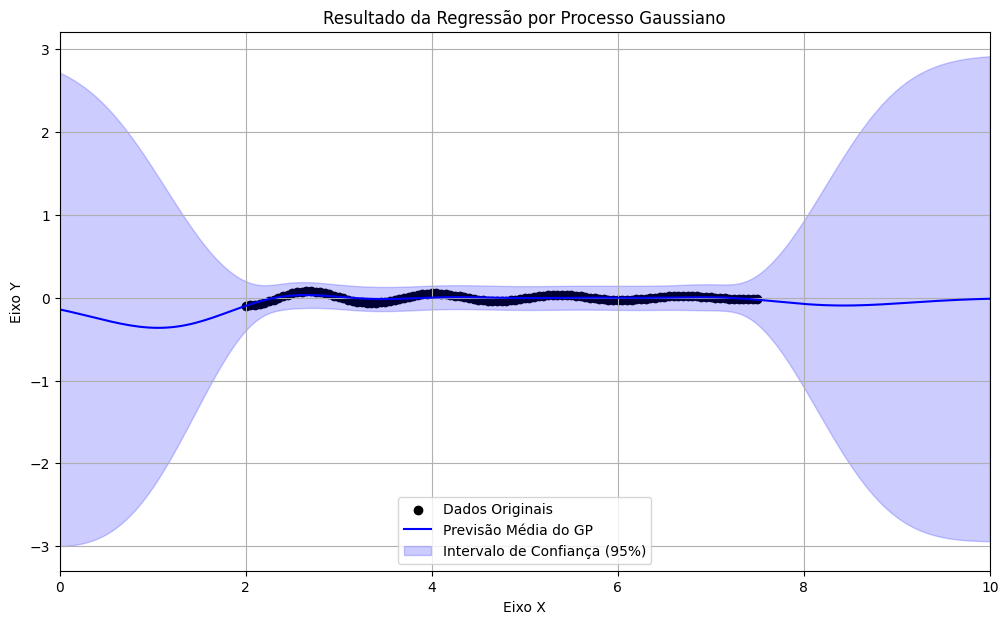

In [15]:
# Vamos calcular o desvio padrão e o intervalo de confiança de 95%
variancia_pred = np.diag(cov_pred)
desvio_padrao_pred = np.sqrt(variancia_pred)
intervalo_confianca = 1.96 * desvio_padrao_pred

#Plot dos dados
plt.figure(figsize=(12, 7))
plt.scatter(x_dados, y_dados, c='black', label='Dados Originais')
plt.plot(x_test, mu_pred, 'b-', label='Previsão Média do GP')
# Curva inferior: mu_pred - intervalo_confianca
# Curva superior: mu_pred + intervalo_confianca
plt.fill_between(x_test, mu_pred - intervalo_confianca, mu_pred + intervalo_confianca,
                 color='blue', alpha=0.2, label='Intervalo de Confiança (95%)')
plt.title('Resultado da Regressão por Processo Gaussiano')
plt.xlabel('Eixo X')
plt.ylabel('Eixo Y')
plt.legend()
plt.grid(True)
plt.xlim(0, 10)
plt.show()